In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Parareal
To solve the initial value problem
$$ u_t = f(t, u), \quad t \in (0, T], // u(0) &= u^0 $$

using the parareal algorithm, we require two integrators or propagators:
\begin{enumerate}
\item $G(t, u)$ is a coarse approximation
\item $F(t, u)$ is a more accurate, or fine, approximation
\end{enumerate}

We partition the time domain into intervals (time-slices, or chunks) and use the coarse approximation $G$ to give us an initial condition for $F$ on each interval.

The more accurate (i.e. \textit{expensive!}) approximation can now be computed in parallel for all slices at once, although obviously the later time slices do not have an accurate initial condition.

We iterate, correcting the initial condition on each interval:
  \begin{align*}
    u_0^{k+1} &= u^0 \\
    u_{n+1}^{k+1} &= F(u_n^k) + G(u_n^{k+1}) - G(u_n^k)
  \end{align*}

my notes:

$$F(u_n^k) = u^{k}_{n+1}$$

Which is the last fine step value at the $n+1$ grid point.

We will first apply parareal to the Lorenz63 chaotic system, using an RK4 method for both the coarse and the fine propagators. The coarse propagator will take a larger timestep than the fine. There are functions provided below to compute the right hand side of the Lorenz system and a single RK4 timestep.

In [2]:
def lorenz63(X, sigma=10, beta=8/3, rho=28):
    """
    Given:
       X: a point of interest in three dimensional space
       sigma, rho, beta: parameters defining the lorenz attractor
    Returns:
       x_dot, y_dot, z_dot: values of the lorenz attractor's partial
           derivatives at the point x, y, z
    """
    x, y, z = X
    xdot = sigma * (y - x)
    ydot = x*(rho - z) - y 
    zdot = x*y - beta*z
    return np.array([xdot, ydot, zdot])

In [3]:
def rk4(dt, x, f, **f_kwargs):
    """
    A single timestep for rhs function f using RK4
    """
    x1 = f(x, **f_kwargs)  

    x2 = f(x+x1*dt/2.0, **f_kwargs)
    x3 = f(x+x2*dt/2.0, **f_kwargs)
    x4 = f(x+x3*dt, **f_kwargs)
    x_out = x + dt*(x1 + 2*x2 + 2*x3 + x4)/6.0
    return x_out

We will reproduce the results from Gander and Hairer 2007. The initial condition and timesteps are given below.

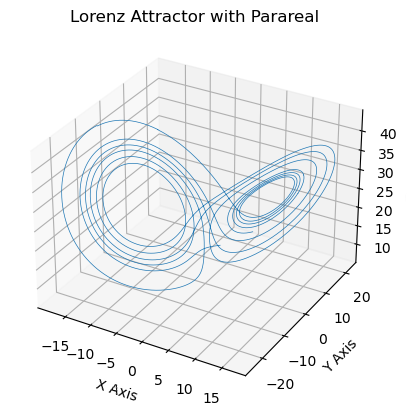

<Figure size 640x480 with 0 Axes>

In [20]:
# initial condition
X0 = np.array([[5, -5, 20]])

# final time
t_max = 10

# total number of coarse timesteps
Nc = 180

# coarse timestep
Dt = t_max/Nc

# total number of fine timesteps
total_Nf = 80 * Nc 

# number of fine timesteps per coarse timestep
Nf = int(total_Nf/Nc)

# fine timestep
dt = t_max/total_Nf

rhs = lorenz63

Xc_old = X0.copy()

# compute the first iteration using the coarse propagator
#### FILL THIS IN
for i in range(Nc-1):
    Xc_old = np.vstack(( Xc_old, (rk4( Dt, Xc_old[i], rhs))[np.newaxis, :] ))

# plt.plot(np.linspace(0, t_max, num=Nc), Xc_old[:, 0])

# number of iterations
nits = 6

Xc_n = Xc_old
Xf_on_c = Xc_n.copy()

Xf_all = []

# now write an iteration loop using the coarse propagator as an initial condition for
# the fine propagator on each time interval
for k in range(nits):
    ### FILL THIS IN
    
    Xc_old = Xc_n.copy()
    
    for i in range(Nc-1):
        Xf = np.array([Xc_old[i]])
    
        for j in range(Nf):
            Xf = np.vstack(( Xf, (rk4( dt, Xf[j], rhs))))
        Xf_on_c[i+1] = Xf[-1]
    
        # if last iteration get all fine timesteps
        if k == (nits - 1):
            Xf_all.append(Xf)           
    
    # Now compute the corrections
    # k index is Xc_old
    # k+1 index is Xc_n
    # Xf_on_c is the fine timestep for iteration k
    # - only those final f values which corr to a course timestep
    # i = n?
    for n in range(Nc-1):
        Xc_n[n+1] = Xf_on_c[n+1] + rk4( Dt, Xc_n[n], rhs ) - rk4( Dt, Xc_old[n], rhs )
    
# plt.plot(np.linspace(0, t_max, num=Nc), Xc_n[:, 0])
# plt.plot(np.linspace(0, t_max, num=Nc), Xc_n[:, 1])
# plt.plot(np.linspace(0, t_max, num=Nc), Xc_n[:, 2])

# stack list with all finetimesteps
Xf_all = np.vstack((Xf_all))

# ax = plt.figure().add_subplot(projection='3d')
# ax.plot(*Xf_all.T, lw=0.5)
# ax.set_xlabel("X Axis")
# ax.set_ylabel("Y Axis")
# ax.set_zlabel("Z Axis")
# ax.set_title("Lorenz Attractor with Parareal")
# plt.show()

# plt.savefig('Lorentz-Parareal-Iter6-180c-14400f-3D-FineSteps.png')

We will now investigate the behaviour of parareal applied to the Dahlquist equation.

## Exercises
1. Apply parareal to the Dahlquist equation with $\lambda=-1$ and initial condition $x=1$. Run until $t=1$ and use 10 coarse timesteps and 20 fine timesteps per coarse timestep.
2. Now set $\lambda=2i$ so that the solution is oscillatory. Investigate the effect of changing the coarse timestep - when does the solution converge? 

In [ ]:
def dahlquist(x, lamda=-1):
    return lamda*x

In [ ]:
def rk4(dt, x, f, **f_kwargs):
    return x/(1-dt*lamda)

In [ ]:
def exact_soln(t, lamda):
    return np.exp(lamda*t)